# 04.04 - Exploratory Data Analysis - Modeling Peak Daily Demand

## Imports & setup

In [1]:
import pathlib
import datetime
from os import PathLike
from typing import Union

#import simplegeneric
import pandas as pd
import numpy as np

from scipy.stats import linregress
import pymc3 as pm

import matplotlib.pyplot as plt
plt.style.use('grayscale')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

pd.set_option('display.max_columns', 100)
plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

## Load Data

In [2]:
dtypes = {'temp': np.float64, 'dew_point_temp':np.float64, 'rel_hum':np.float64,
          'wind_speed': np.float64, 'visibility': np.float64, 'press': np.float64,
          'hmdx': np.float64, 'wind_chill': np.float64, 'weather': np.object,
         'hour_of_day': np.float64, 'year': np.float64, 'month': np.float64,
         'day_of_week': np.float64, 'day_of_year': np.float64, 'week_of_year': np.float64,
          'quarter': np.float64, 'stat_hol': 'category', 'day_light_hours': 'category',
          'hourly_demand': np.float64, 'daily_peak': np.float64}

df_orig = pd.read_csv(CLEAN_DATA_DIR / "clean.csv", parse_dates=True,
                 dtype=dtypes, index_col=0, infer_datetime_format=True)

daymapper = {0.0: 'Mon', 1.0: 'Tue', 2.0: 'Wed', 3.0: 'Thu', 4.0: 'Fri', 5.0: 'Sat', 6.0: 'Sun'}
weekdaymapper = {0.0: 'Weekday', 1.0: 'Weekday', 2.0: 'Weekday', 3.0: 'Weekday', 4.0: 'Weekday',
                 5.0: 'Weekend', 6.0: 'Weekend'}
df_orig['dayofweek'] = df_orig['day_of_week'].map(daymapper)
df_orig['daytype'] = df_orig['day_of_week'].map(weekdaymapper)


In [3]:
df_orig.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,year,month,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
1994-01-01 00:00:00,-1.2,-3.8,83.0,15.0,19.3,99.91,NaN,-6.0,Cloudy,0.0,1994.0,1.0,5.0,1.0,52.0,1.0,True,False,14422.0,16892.0,Sat,Weekend
1994-01-01 01:00:00,-0.9,-3.0,86.0,20.0,16.1,99.91,NaN,-6.0,Cloudy,1.0,1994.0,1.0,5.0,1.0,52.0,1.0,True,False,13845.0,16892.0,Sat,Weekend
1994-01-01 02:00:00,-0.7,-3.2,83.0,15.0,16.1,99.87,NaN,-5.0,Cloudy,2.0,1994.0,1.0,5.0,1.0,52.0,1.0,True,False,13372.0,16892.0,Sat,Weekend
1994-01-01 03:00:00,-0.8,-2.4,89.0,15.0,12.9,99.81,NaN,-5.0,Cloudy,3.0,1994.0,1.0,5.0,1.0,52.0,1.0,True,False,13025.0,16892.0,Sat,Weekend
1994-01-01 04:00:00,-1.0,-3.3,84.0,19.0,16.1,99.77,NaN,-6.0,Mostly Cloudy,4.0,1994.0,1.0,5.0,1.0,52.0,1.0,True,False,12869.0,16892.0,Sat,Weekend


In [4]:
df2006 = df_orig.loc['2006', :].copy(deep=True)
df2006.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,year,month,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
2006-01-01 00:00:00,-5.2,-7.4,84.0,7.0,19.3,98.90,NaN,-8.0,Cloudy,0.0,2006.0,1.0,6.0,1.0,52.0,1.0,True,False,15925.0,18371.0,Sun,Weekend
2006-01-01 01:00:00,-5.0,-7.0,86.0,0.0,19.3,98.96,NaN,NaN,Cloudy,1.0,2006.0,1.0,6.0,1.0,52.0,1.0,True,False,15323.0,18371.0,Sun,Weekend
2006-01-01 02:00:00,-5.4,-6.3,93.0,4.0,4.0,99.01,NaN,-7.0,Fog,2.0,2006.0,1.0,6.0,1.0,52.0,1.0,True,False,14832.0,18371.0,Sun,Weekend
2006-01-01 03:00:00,-5.0,-5.6,96.0,4.0,2.0,99.05,NaN,-7.0,Fog,3.0,2006.0,1.0,6.0,1.0,52.0,1.0,True,False,14502.0,18371.0,Sun,Weekend
2006-01-01 04:00:00,-4.6,-5.2,96.0,0.0,2.0,99.08,NaN,NaN,Fog,4.0,2006.0,1.0,6.0,1.0,52.0,1.0,True,False,14392.0,18371.0,Sun,Weekend


## Relationship Between Temperature and Power Demand 

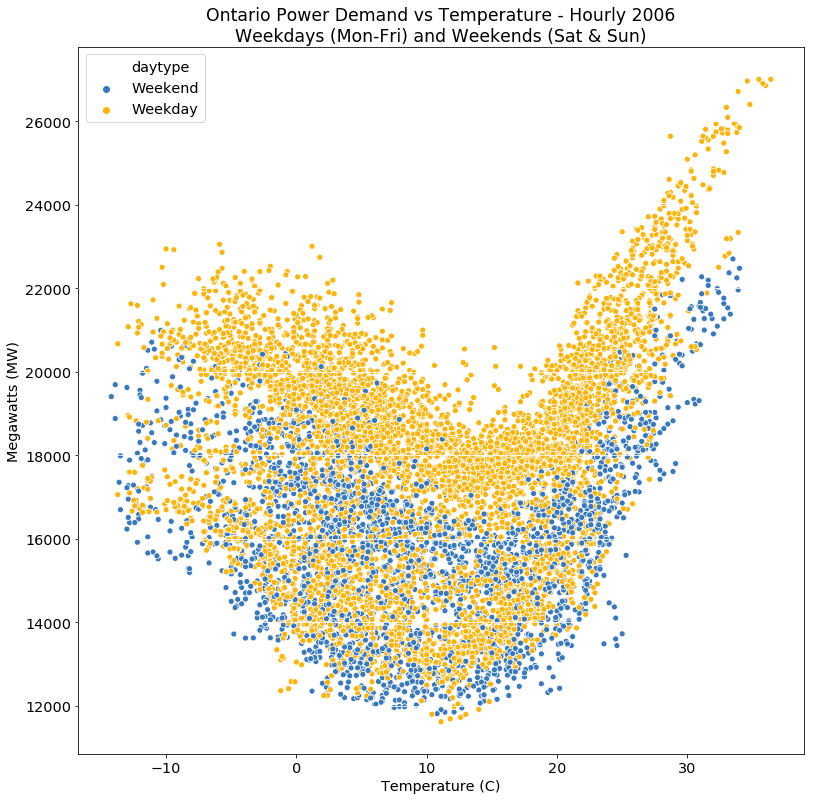

In [5]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
fig, ax = plt.subplots(frameon=False, figsize=(13,13))
sns.scatterplot(x="temp", y="hourly_demand",
                hue="daytype",
                hue_order=['Weekend', 'Weekday'],
                data=df2006, ax=ax, legend='full')
#plt.title('')
ax.set_ylabel('Megawatts (MW)')
ax.set_xlabel('Temperature (C)')
ax.set_title('Ontario Power Demand vs Temperature - Hourly 2006\nWeekdays (Mon-Fri) and Weekends (Sat & Sun)')
#plt.savefig('saved-images/ontario-power-demand-vs-temperature-hourly-2006-scatterplot.PNG')
plt.show();

## Relationship Between Maximum Daily Temperature and Maximum Daily Power Demand for Summer Weekdays

In [6]:
weekdays = df_orig[df_orig['daytype'] == 'Weekday']
weekdays_max_data = weekdays.loc['2006-06' : '2006-09', :].resample('D').max().dropna(subset=['daytype'])
weekdays_max_data.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,year,month,day_of_week,day_of_year,week_of_year,quarter,hourly_demand,daily_peak,dayofweek,daytype
2006-06-01,22.1,19.3,96.0,24.0,24.1,99.66,27.0,NaN,"Rain Showers,Fog",23.0,2006.0,6.0,3.0,152.0,22.0,2.0,20320.0,20320.0,Thu,Weekday
2006-06-02,22.9,16.0,97.0,17.0,24.1,99.49,27.0,NaN,"Thunderstorms,Moderate Rain Showers",23.0,2006.0,6.0,4.0,153.0,22.0,2.0,19726.0,19726.0,Fri,Weekday
2006-06-05,26.0,12.7,63.0,26.0,24.1,99.33,28.0,NaN,Mostly Cloudy,23.0,2006.0,6.0,0.0,156.0,23.0,2.0,20036.0,20036.0,Mon,Weekday
2006-06-06,25.2,12.1,66.0,17.0,24.1,99.50,27.0,NaN,Mostly Cloudy,23.0,2006.0,6.0,1.0,157.0,23.0,2.0,20465.0,20465.0,Tue,Weekday
2006-06-07,27.1,13.5,75.0,19.0,24.1,99.30,29.0,NaN,Mostly Cloudy,23.0,2006.0,6.0,2.0,158.0,23.0,2.0,21249.0,21249.0,Wed,Weekday


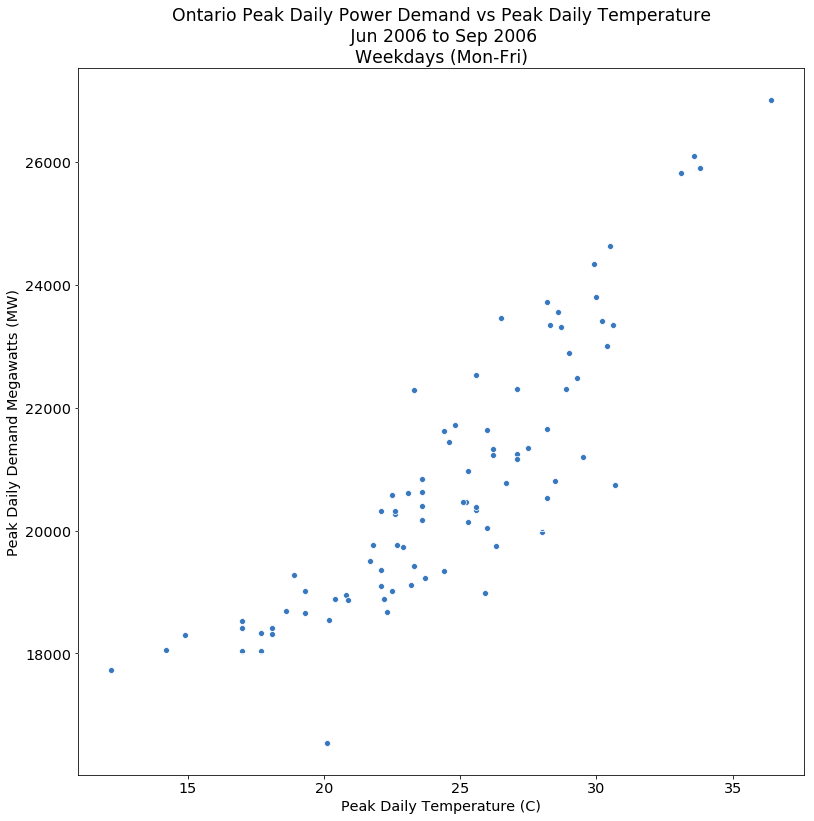

In [7]:
fig, ax = plt.subplots(frameon=False, figsize=(13,13))
sns.scatterplot(x="temp", y="daily_peak",
                data=weekdays_max_data, ax=ax)
ax.set_ylabel('Peak Daily Demand Megawatts (MW)')
ax.set_xlabel('Peak Daily Temperature (C)')
ax.set_title('Ontario Peak Daily Power Demand vs Peak Daily Temperature\n Jun 2006 to Sep 2006\n\
Weekdays (Mon-Fri)')
#plt.savefig('saved-images/ontario-power-demand-vs-temperature-hourly-jun2006-sep2006-scatterplot.PNG')
plt.show();

In [8]:
x = weekdays_max_data['temp'].values
y = weekdays_max_data['daily_peak'].values
y[0:5]

array([20320., 19726., 20036., 20465., 21249.])

### Functions

In [9]:
def ecdf(data):
    """Accepts an sequence of numerical data
       Returns x, y where x is the index of the data
       and y is the data value
       Returned data is used to plot an empirical cumulative density function
       """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n +1) / n
    return x, y

### Power Demand Distribution - Summer 2006

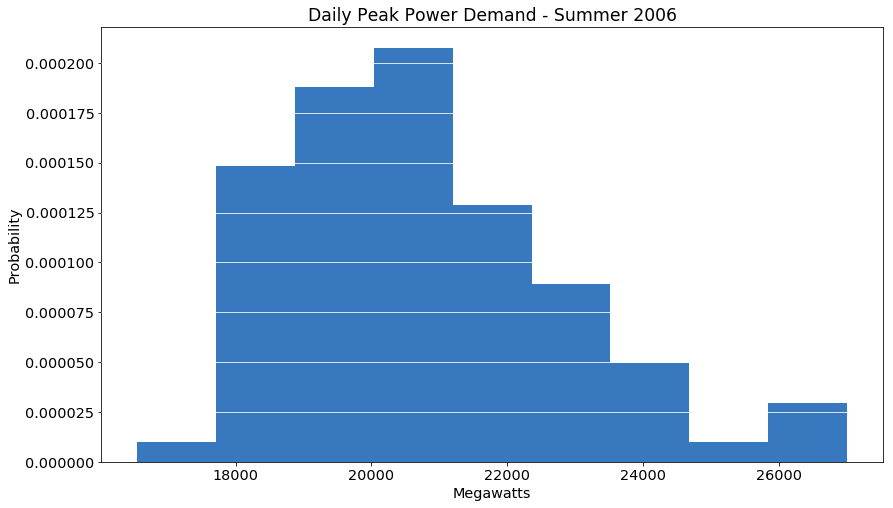

In [10]:
# Put histogram here and identify dual peak
bins=int(np.sqrt(len(y)))
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(y, bins = bins, density=True)
ax.set_ylabel('Probability')
ax.set_xlabel('Megawatts')
ax.set_title('Daily Peak Power Demand - Summer 2006')
plt.show();

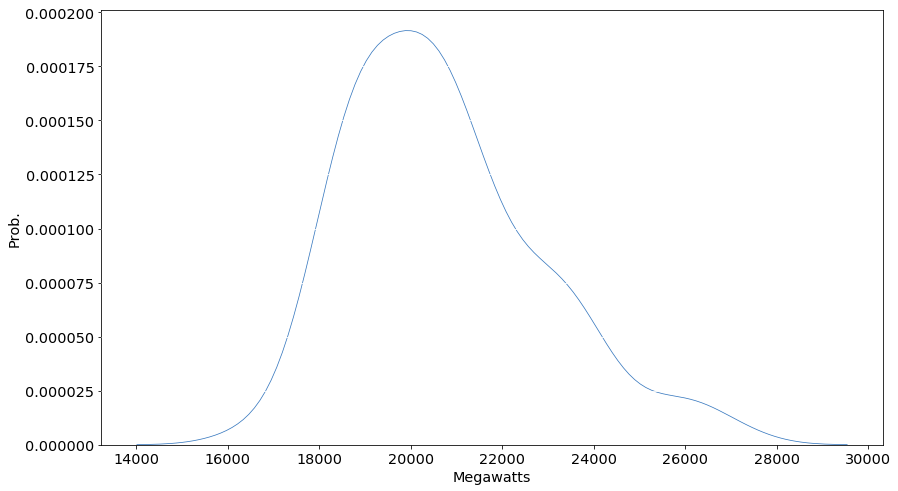

In [11]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_xlabel('Megawatts')
ax.set_ylabel('Prob.')
sns.kdeplot(y, ax=ax);

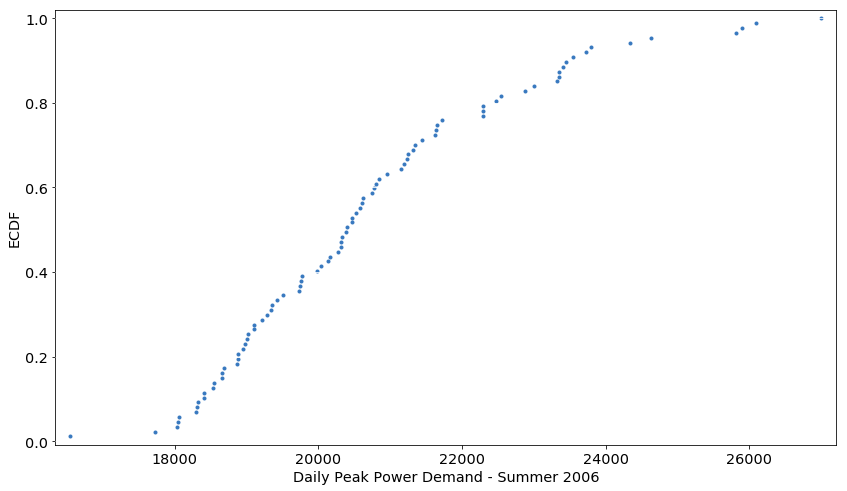

In [12]:
xp, yp = ecdf(y)
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(xp, yp, marker='.', linestyle='none')
ax.margins(0.02)
ax.set_xlabel('Daily Peak Power Demand - Summer 2006')
ax.set_ylabel('ECDF')
plt.show();

### Temperature - Summer 2006

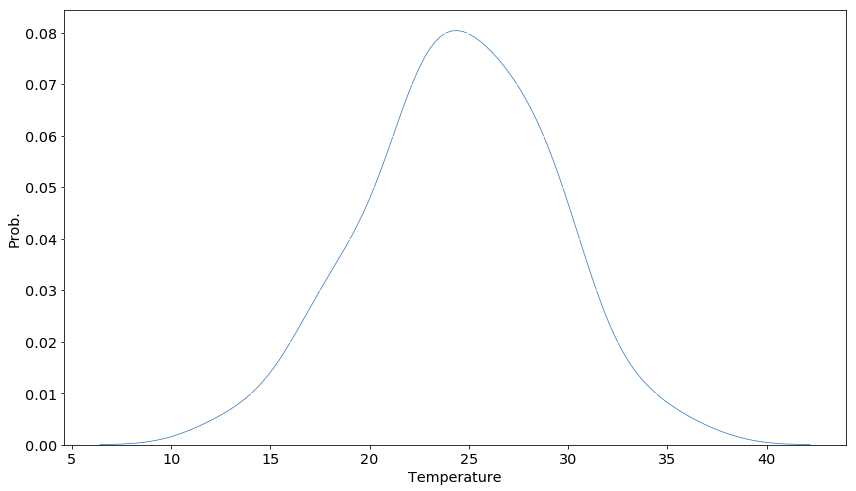

In [13]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_xlabel('Temperature')
ax.set_ylabel('Prob.')
sns.kdeplot(x, ax=ax);

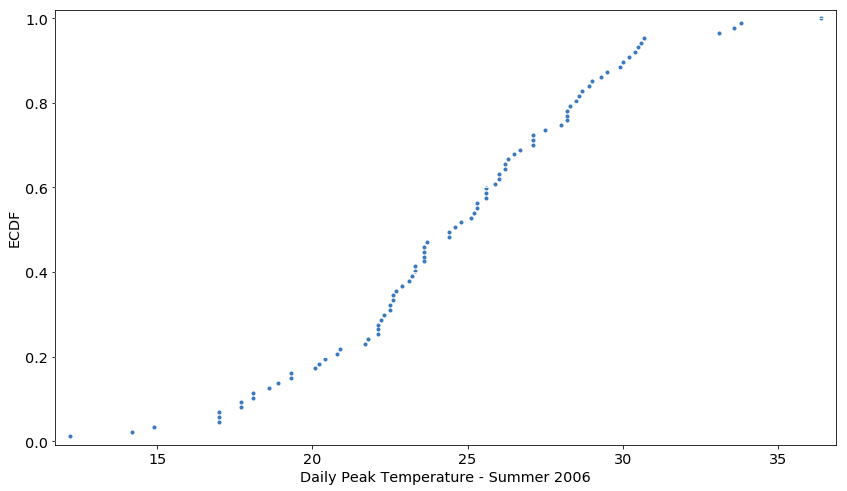

In [14]:
xt, yt = ecdf(x)
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(xt, yt, marker='.', linestyle='none')
ax.margins(0.02)
ax.set_xlabel('Daily Peak Temperature - Summer 2006')
ax.set_ylabel('ECDF')
plt.show();

## Comparing Linear Regression Techniques

Apply Linear Regression to Summer Power Demand vs Temperature Data in 3 (and a half) ways

+ 1 Frequentist
+ 2 Bootstrap
+ 3 Bayesian - Gaussian Model
+ 3.5 Bayesian - Students t Distribution (Robust)

## Frequentist

In [15]:
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(f'slope:\t\t{slope}')
print(f'intercept:\t{intercept}')
print(f'p_value:\t{p_value}')
print(f'std_err:\t{std_err}')

slope:		395.87218255400893
intercept:	11041.364687935959
p_value:	7.346442449823172e-28
std_err:	24.312936680034856


The slope indicates that powerr demand increases by an average 462 MW for every degree increase in temperature

The intercept provides a reference point to place the regression line, but the intercept value itself is not meaningful in that the intercept will never be crossed. This is because the poweer demand has a U shape whereby demand increases with both higher and lower temperatures.

The low p value suggests there is strong evidence to reject the null hypothesis that temperature is related to power demand

The standard error represents the average distance between the observed points and the regression line. Approximately 95% of the observed points should fit within 2 standard errors distance each side of the regression line.  


## Bootstrap

First, fit the regression line using the standard frequentist technique - equivalent to shown above

In [16]:
poly_degrees = 1
a,b = np.polyfit(x, y, poly_degrees)
# Print the results to the screen
print('slope =', a, 'additional Megawatts for every degree increase in Temperature')
print('intercept =', b, 'Not directly relevant, due to shape of full function')

slope = 395.87218255400904 additional Megawatts for every degree increase in Temperature
intercept = 11041.364687935953 Not directly relevant, due to shape of full function


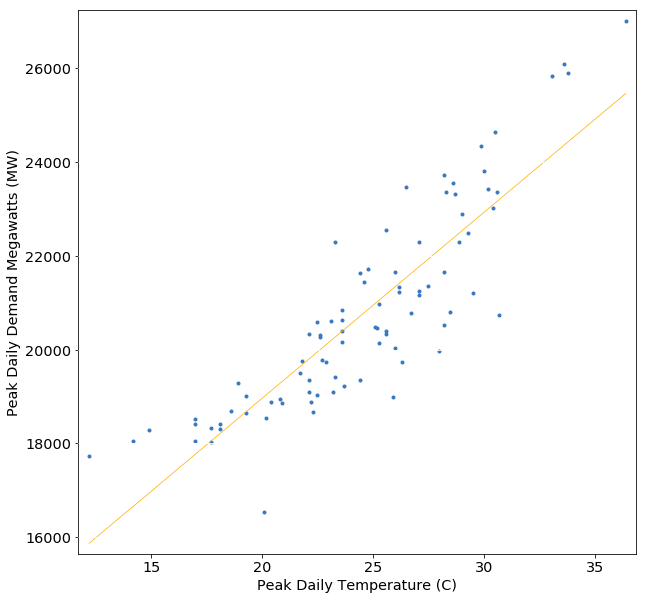

In [17]:
# Make theoretical line to plot
xt = np.array([np.min(x), np.max(x)])
yt = a * xt + b

fig, ax = plt.subplots(frameon=False, figsize=(10,10))
ax.plot(x, y, marker='.', linestyle='none')
ax.margins(0.02)
ax.set_ylabel('Peak Daily Demand Megawatts (MW)')
ax.set_xlabel('Peak Daily Temperature (C)')
# Add regression line to your plot
ax.plot(xt, yt)
plt.show()

To complete the bootstrap, we will sample with replacement from the full dataset, selecting one pair of data points each time.


In [18]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, poly_degrees)

    return bs_slope_reps, bs_intercept_reps

[338.59135987 454.027063  ]
396.6219649696155
29.35908110982541


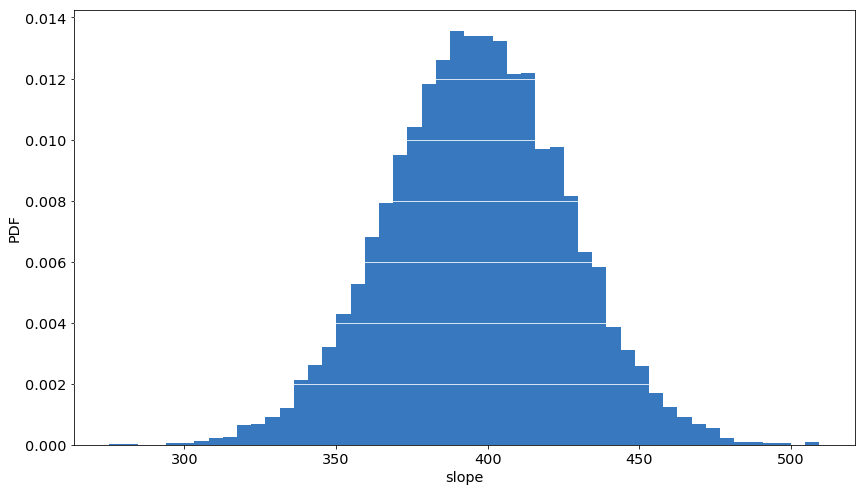

In [19]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
                    x, y, size=10000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))
print(np.mean(bs_slope_reps))
print(np.std(bs_slope_reps))

# Make a histogram of the results
fig, ax = plt.subplots(frameon=False, figsize=(14,8))
ax.hist(bs_slope_reps, bins=50, density=True)
ax.set_xlabel('slope')
ax.set_ylabel('PDF')
plt.show();

[337.51771714 453.30421572]
11024.933193176335
706.3135569419459


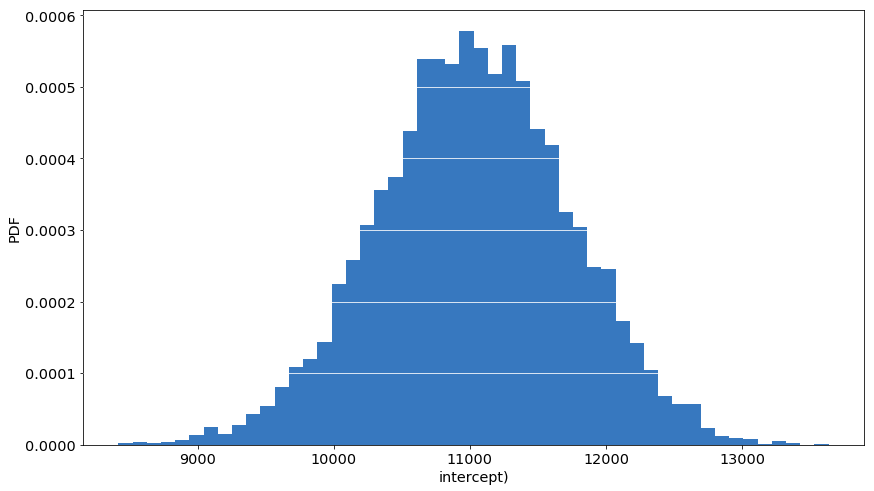

In [20]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
                    x, y, size=10000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))
print(np.mean(bs_intercept_reps))
print(np.std(bs_intercept_reps))

# Make a histogram of the results
fig, ax = plt.subplots(frameon=False, figsize=(14,8))
ax.hist(bs_intercept_reps, bins=50, density=True)
ax.set_xlabel('intercept)')
ax.set_ylabel('PDF')
plt.show();

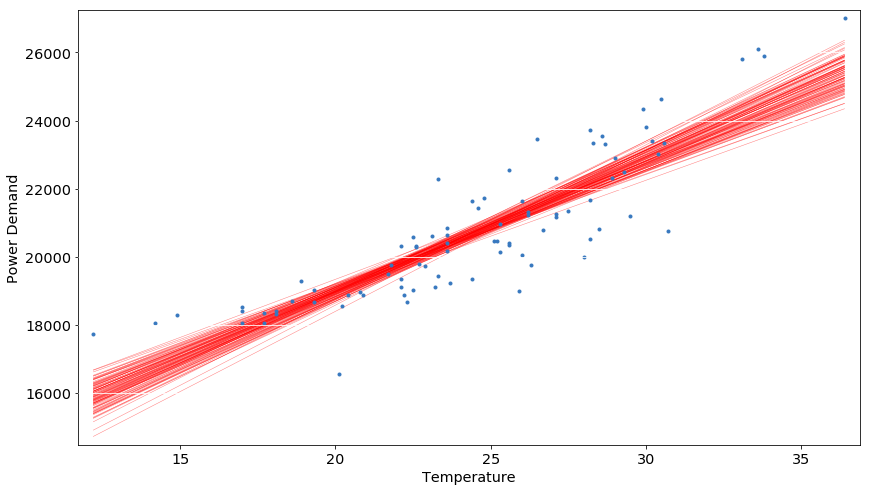

In [21]:
# Generate array of x-values for bootstrap lines: x
xtt = np.array([np.min(x), np.max(x)])

fig, ax = plt.subplots(frameon=False, figsize=(14,8))
# Plot the first n bootstrap lines
for i in range(100):
    ax.plot(xtt, bs_slope_reps[i] * xtt + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.5, color='red')
ax.plot(x, y, marker='.', linestyle='none')

ax.set_xlabel('Temperature')
ax.set_ylabel('Power Demand')
plt.margins(0.02)
plt.show();

I like it!

Bootstrap techniques are pretty flexible, and dead easy to understand by just following the code.

Understandable method to get an idea of the sample variation



## Bayesian Linear Regression

We will use our bootstrap analysis to inform how we set up the prior distribution parameters.

I will use the values close to the means, but the standard deviations above are for the sampling distribution, not the parameter, so I choose a relatively large arbitrary value

$$y \sim N(\mu = \alpha + \beta x,\; \sigma= \epsilon)$$

In [22]:
with pm.Model() as model:
    # Intercept
    alpha = pm.Normal('alpha', mu=8000, sd=4000)
    # Slope
    beta = pm.Normal('beta', mu=500, sd=4000)
    # Error 
    epsilon = pm.HalfCauchy('epsilon', 4000)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    #start = pm.find_MAP()
    start = pm.sample(tune=1000)
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:06<00:00, 973.82draws/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 10500/10500 [00:04<00:00, 2431.42it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


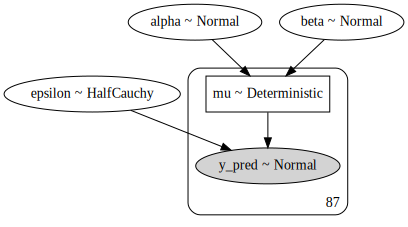

In [23]:
pm.model_to_graphviz(model)

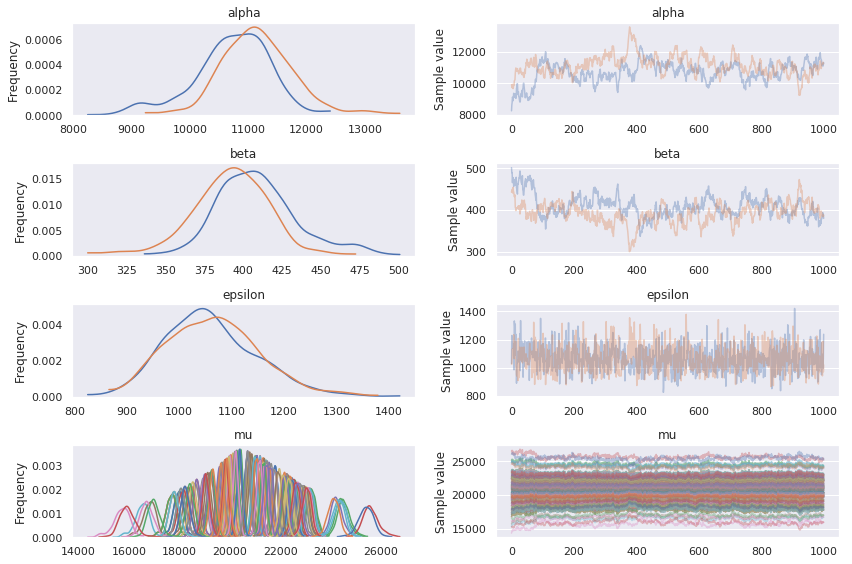

In [24]:
sns.set()
pm.traceplot(trace[::10])
plt.show();

In [25]:
pm.summary(trace).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,10931.542550,668.996436,59.573131,9562.475097,12393.230639,11.894454,1.123628
beta,400.229457,26.801034,2.369793,343.629637,456.839094,12.041735,1.121493
epsilon,1062.335629,86.799374,2.346479,904.786796,1236.712224,1469.389509,1.000763
mu__0,19776.613550,132.933607,7.371110,19509.811996,20033.916008,37.242423,1.044576
mu__1,20096.797116,123.568086,5.542079,19855.519447,20342.715774,75.097383,1.027922


In [26]:
pm.summary(trace).tail()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__82,17735.443320,233.665009,19.336105,17239.638667,18206.562094,13.887693,1.105697
mu__83,18175.695722,208.504138,16.740728,17748.977818,18606.753111,14.827628,1.099044
mu__84,19856.659442,130.324904,6.910477,19589.729404,20103.229091,42.504733,1.040435
mu__85,16894.961460,284.016913,24.297690,16301.132497,17490.589985,12.933458,1.113536
mu__86,15814.341926,351.409294,30.684001,15057.792173,16539.031561,12.400466,1.118624


The 95% Highest Posterior Density Interval for the:
+ intercept: 7001 to 9690 with a mean of 8360 - (This changes slightly each run)
+ slope: 413 to 519 with a mean of 466 - (This changes slightly each run)

These seem pretty wide, with the means comparable to the priors. However, the frequentist results were used to set the priors, so maybe this should not be surprising. I gues if the posterior does not shift too much from the prior, then the data is not having too great an impact?

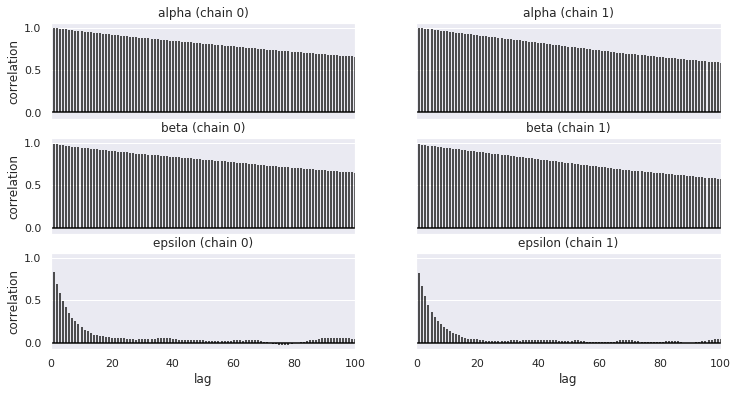

In [27]:
sns.set()
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)
plt.show();

In [28]:
ppc1 = pm.sample_posterior_predictive(trace, samples=231, model=model)

100%|██████████| 231/231 [00:00<00:00, 817.64it/s]


In [29]:
ppc1

{'y_pred': array([[18824.51999235, 18982.56410373, 21291.53507236, ...,
         19234.75835529, 15229.5067417 , 13680.21536013],
        [21051.2471543 , 19948.62511423, 22222.11892671, ...,
         19544.10729953, 15694.49643425, 12739.57111828],
        [19832.08511161, 20326.95312194, 20771.00538972, ...,
         18834.19036681, 15545.27447253, 13632.99002907],
        ...,
        [19146.05604717, 19034.36133955, 20357.4582549 , ...,
         20522.07110774, 14386.11747611, 16009.6240599 ],
        [19244.06940836, 20660.01735402, 18546.31874116, ...,
         19023.45196232, 17151.57773229, 15726.30532467],
        [18800.34327352, 17141.70978163, 21280.72770209, ...,
         20732.92494575, 15987.59226731, 14518.36425288]])}

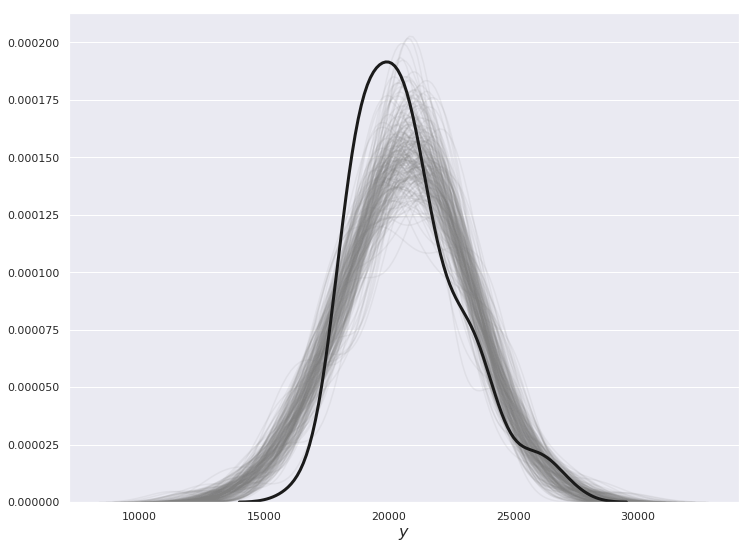

In [30]:
plt.figure(figsize=(12,9))
# predicted data
for y_tilde in ppc1[('y_pred')]:
    sns.kdeplot(y_tilde, alpha=0.1, color='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);

## Bayesian Robust Linear Regression

Use the t distribution, to give more flexibility in fitting the model

Everything the same as before, but model the y distribution as a students t distribution. This means an extra parameter is introduced nu - the degrees of freedom

The t distribution is more flexible than the normal distribution and should give a better fit

In [31]:
with pm.Model() as model_t:
    # Intercept
    alpha = pm.Normal('alpha', mu=8000, sd=4000)
    # Slope
    beta = pm.Normal('beta', mu=500, sd=4000)
    # Error 
    epsilon = pm.HalfCauchy('epsilon', 4000)

    #mu = pm.Deterministic('mu', alpha + beta * x)
    # About 90 data points nu is 1/ddof
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/90) + 1)
    y_pred = pm.StudentT('y_pred', mu=alpha + beta *x, sd=epsilon, nu=nu, observed=y)
    
    #start = pm.find_MAP()
    start = pm.sample(tune=1000)
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_, epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:08<00:00, 713.94draws/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [nu_]
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 10500/10500 [00:06<00:00, 1521.66it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


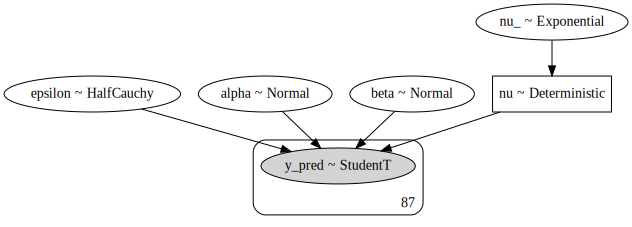

In [32]:
pm.model_to_graphviz(model_t)

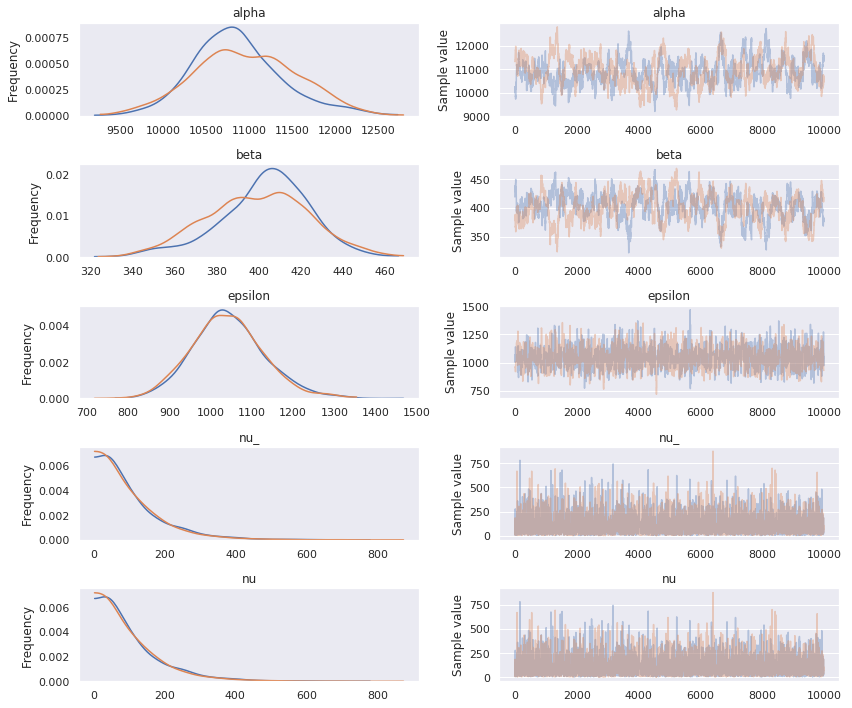

In [33]:
sns.set()
pm.traceplot(trace)
plt.show();

In [34]:
pm.summary(trace).head(10)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,10905.272033,561.787740,42.365605,9833.903621,12067.244194,121.983511,1.007671
beta,401.426585,22.831861,1.723806,355.550229,447.253860,122.137173,1.007078
epsilon,1043.584160,86.954106,2.179804,868.935430,1209.014518,1389.767379,1.000802
nu_,104.334465,92.131874,1.324762,2.718388,284.760637,4419.740364,1.000202
nu,105.334465,92.131874,1.324762,3.718388,285.760637,4419.740364,1.000202


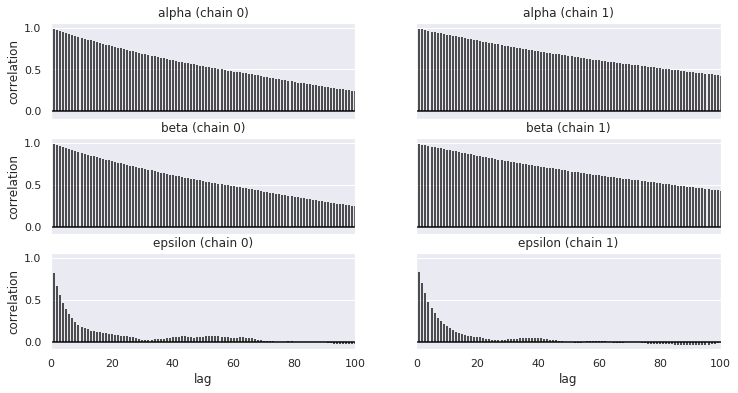

In [35]:
sns.set()
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)
plt.show();

In [36]:
ppc2 = pm.sample_posterior_predictive(trace, samples=231, model=model_t)
ppc2

100%|██████████| 231/231 [00:00<00:00, 1117.62it/s]


{'y_pred': array([[19406.72438106, 18916.85012779, 21397.47892215, ...,
         19314.79645041, 15858.45889937, 15114.23631385],
        [18405.27769623, 19862.62364273, 21642.19933819, ...,
         19547.16194245, 17547.78178455, 15360.27740049],
        [17933.14296515, 22005.23353686, 21680.62067757, ...,
         20135.96931725, 17842.81743218, 18814.79251376],
        ...,
        [21657.25983982, 19838.64492415, 21096.4060273 , ...,
         20045.49544026, 16588.96467968, 14477.49335082],
        [19024.30393492, 20743.73665055, 22402.73821308, ...,
         19644.78064246, 17081.58184705, 16370.47958712],
        [20954.12541995, 20242.35072304, 20786.01028404, ...,
         19928.54680388, 17131.53069298, 16718.71903306]])}

### Robust Model - Students t

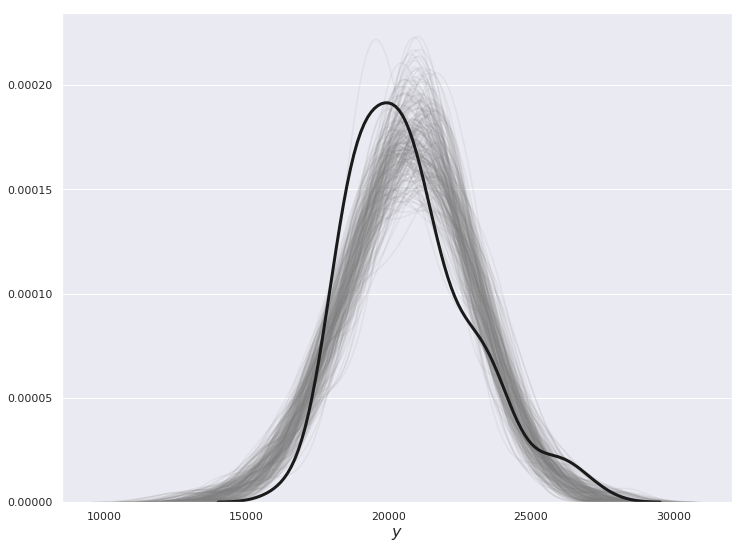

In [37]:
plt.figure(figsize=(12,9))
# predicted data
for y_tilde in ppc2[('y_pred')]:
    sns.kdeplot(y_tilde, alpha=0.1, color='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);

### Comparing Models

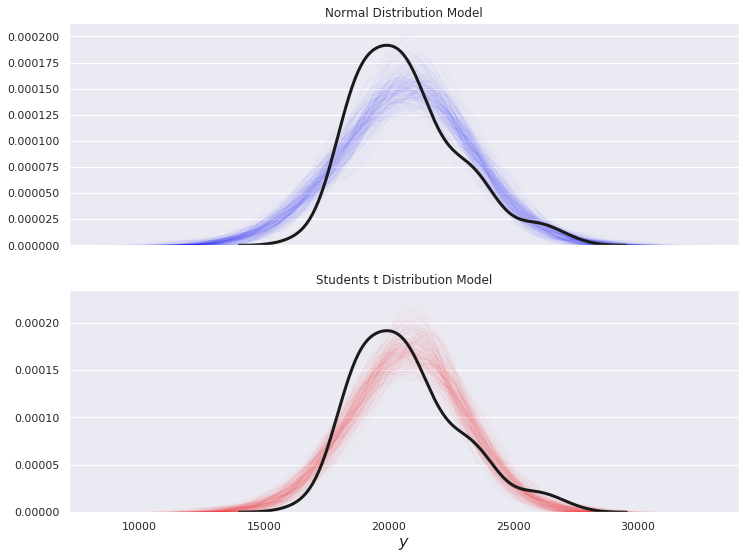

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,9))
#fig, ax = plt.subplots(figsize=(12,9))
# predicted data
for y_tilde in ppc1[('y_pred')]:
    sns.kdeplot(y_tilde, alpha=0.01, color='blue', ax=ax1)
for y_tilde in ppc2[('y_pred')]:
    sns.kdeplot(y_tilde, alpha=0.01, color='red', ax=ax2)
ax1.set_title('Normal Distribution Model')
ax2.set_title('Students t Distribution Model')

# actual data
sns.kdeplot(y, linewidth=3, color='k', ax=ax1)
sns.kdeplot(y, linewidth=3, color='k', ax=ax2)
plt.xlabel('$y$', fontsize=16);

Virtually no difference between models.

Perhaps additional data would help shift the posterior

Addisional model complexity does not seem to be justified in this case.

I think you need a solid understanding of probability and building models to get further with bayesian stats. However, it seems extremely adaptable, and I think anything could be modeled.

The model is completely explicit, and the posterior can be interpreted as a straight-forward distribution of possible values. 

### Summary
+ Frequentist - Easy to apply, not easy to fully understand
+ Bootstrap - easy to apply, easy to understand logic. Non-parametric.
+ Bayesian - Everything depends on setting up the model. This has to be the best way to understand all the assumptions going into the model. Worth pursuing, but seems like a bit of a learning curve to get a good understanding.